In [30]:
# Imports comuns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from PIL import Image
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [31]:
LABEL_PATH = Path("../data/labels/labels_task1.csv")
FRAME_DIR = Path("../data/frames")
df = pd.read_csv(LABEL_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Apenas vídeos com frames extraídos
available_videos = {p.name for p in FRAME_DIR.iterdir() if p.is_dir() and any(p.glob("*.jpg"))}
df = df[df["VIDEO"].isin(available_videos)].reset_index(drop=True)
df.head()

,VIDEO,GRS
0,A31H,0
1,A36O,0
2,A40E,1
3,A41X,3
4,A59Z,0


In [32]:
class GRSDataset(Dataset):
    def __init__(self, dataframe, frame_dir, transform=None, sequence_length=16):
        self.data = dataframe
        self.frame_dir = frame_dir
        self.transform = transform
        self.sequence_length = sequence_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        video_id = row["VIDEO"]
        label = row["GRS"]
        path = self.frame_dir / video_id

        frames = sorted(path.glob("*.jpg"))
        selected = frames[:self.sequence_length]
        if len(selected) == 0:
            raise IndexError(f"Sem frames em {video_id}")
        while len(selected) < self.sequence_length:
            selected.append(selected[-1])

        images = [self.transform(Image.open(f).convert("RGB")) for f in selected]
        return torch.stack(images), label

In [33]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = GRSDataset(df, FRAME_DIR, transform)
loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [34]:
class CNNLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.cnn.fc = nn.Identity()
        self.lstm = nn.LSTM(512, 128, batch_first=True)
        self.fc = nn.Linear(128, 4)

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        feats = self.cnn(x)
        feats = feats.view(B, T, 512)
        _, (hn, _) = self.lstm(feats)
        return self.fc(hn[-1])

In [35]:
class CNNMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.cnn.fc = nn.Identity()
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        B, T, C, H, W = x.shape
        x = x.view(B * T, C, H, W)
        feats = self.cnn(x)
        feats = feats.view(B, -1)
        return self.fc(feats)

In [36]:
class CNNLastFrame(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.cnn.fc = nn.Linear(512, 4)

    def forward(self, x):
        return self.cnn(x[:, -1])  # usa só o último frame

In [37]:
def train_model(model, dataloader, epochs=5):
    model.to(device)
    opt = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    history = []

    for epoch in range(epochs):
        model.train()
        correct, total, loss_sum = 0, 0, 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = loss_fn(out, y)

            opt.zero_grad()
            loss.backward()
            opt.step()

            loss_sum += loss.item()
            pred = out.argmax(1)
            correct += (pred == y).sum().item()
            total += y.size(0)

        acc = correct / total
        print(f"Epoch {epoch+1}: Loss={loss_sum:.4f}, Acc={acc:.4f}")
        history.append((loss_sum, acc))

    return history


In [38]:
model1 = CNNLSTM()
hist1 = train_model(model1, loader)

model2 = CNNMLP()
hist2 = train_model(model2, loader)

model3 = CNNLastFrame()
hist3 = train_model(model3, loader)

Epoch 1: Loss=10.3746, Acc=0.4333
Epoch 2: Loss=6.7630, Acc=0.9000
Epoch 3: Loss=4.6674, Acc=0.9667
Epoch 4: Loss=3.3917, Acc=1.0000
Epoch 5: Loss=1.9938, Acc=1.0000
Epoch 1: Loss=12.8021, Acc=0.4000
Epoch 2: Loss=5.8056, Acc=0.6667
Epoch 3: Loss=2.6591, Acc=0.9667
Epoch 4: Loss=1.0977, Acc=1.0000
Epoch 5: Loss=0.5731, Acc=1.0000
Epoch 1: Loss=10.7462, Acc=0.3667
Epoch 2: Loss=3.9796, Acc=0.8000
Epoch 3: Loss=2.5538, Acc=0.9333
Epoch 4: Loss=1.0215, Acc=1.0000
Epoch 5: Loss=1.1357, Acc=1.0000


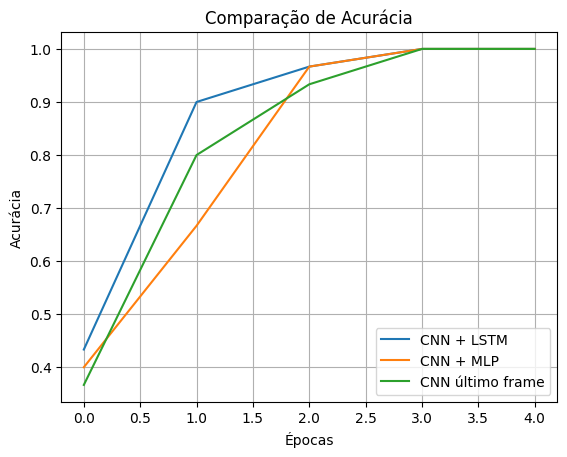

In [39]:
plt.plot([h[1] for h in hist1], label="CNN + LSTM")
plt.plot([h[1] for h in hist2], label="CNN + MLP")
plt.plot([h[1] for h in hist3], label="CNN último frame")
plt.title("Comparação de Acurácia")
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.legend()
plt.grid()
plt.show()


In [40]:
torch.save(model1.state_dict(), "../outputs/models/model_task1_best.pt")
print("Modelo 1 salvo como melhor.")

Modelo 1 salvo como melhor.
